In [26]:
# Add module folder to notebook
import os
import sys

from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv()))

In [32]:
from snowflake.snowpark import functions, types
from snowflake.ml.modeling.linear_model import LogisticRegression
from snowflake.ml.modeling.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import datetime
import pandas
import seaborn

from app.snowpark_session.session import snowpark_session

In [8]:
session = snowpark_session()

In [9]:
session.use_database('HOL_DB')

In [10]:
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "LEIT_WH"


## Model Building

We will use the balanced data set created in 1.3

In [11]:
application_record_balanced_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
application_record_balanced_sdf.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,0,29819
1,1,29819


We are going to use stratified sampling of the data. Using `sample_by` allows us to sample based on one column and also specify the fractions of each value in the column.
Minus command is an alias of `except_` which is same as EXCEPT in sql.

In [12]:
sample = {1: 0.8, 0: 0.8}

train_sdf = application_record_balanced_sdf.sample_by('TARGET', sample)
train_sdf = train_sdf.cache_result()
train_sdf.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,1,23998
1,0,23977


The test data set is the rest of the rows, by using *minus* we can exclude the rows from the train_sdf DataFrame

In [13]:
test_sdf = application_record_balanced_sdf.minus(train_sdf)
test_sdf.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,0,5842
1,1,5651


Save the training and test data into tables

In [14]:
train_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN', mode='overwrite')
test_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST', mode='overwrite')

train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

Fit a LogisticRegression model using snowpark-ml, the fitting is pushed down to Snowflake and is using scikit-learn behind the scene.

In [15]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

lm = LogisticRegression(
    C=0.8, 
    solver='lbfgs',
    random_state=0, 
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols=['PREDICTION']
    )
lm.fit(train_sdf)

The version of package 'snowflake-snowpark-python' in the local environment is 1.9.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy==1.25.2'. Your UDF might not work when the package version is different between the server and your local environment.


The fitted model can be retrieved as a scikit-learn object

In [16]:
lm_local = lm.to_sklearn()
lm_local

LogisticRegression(C=0.8, random_state=0)

Plot Feature Coefficients

<Axes: >

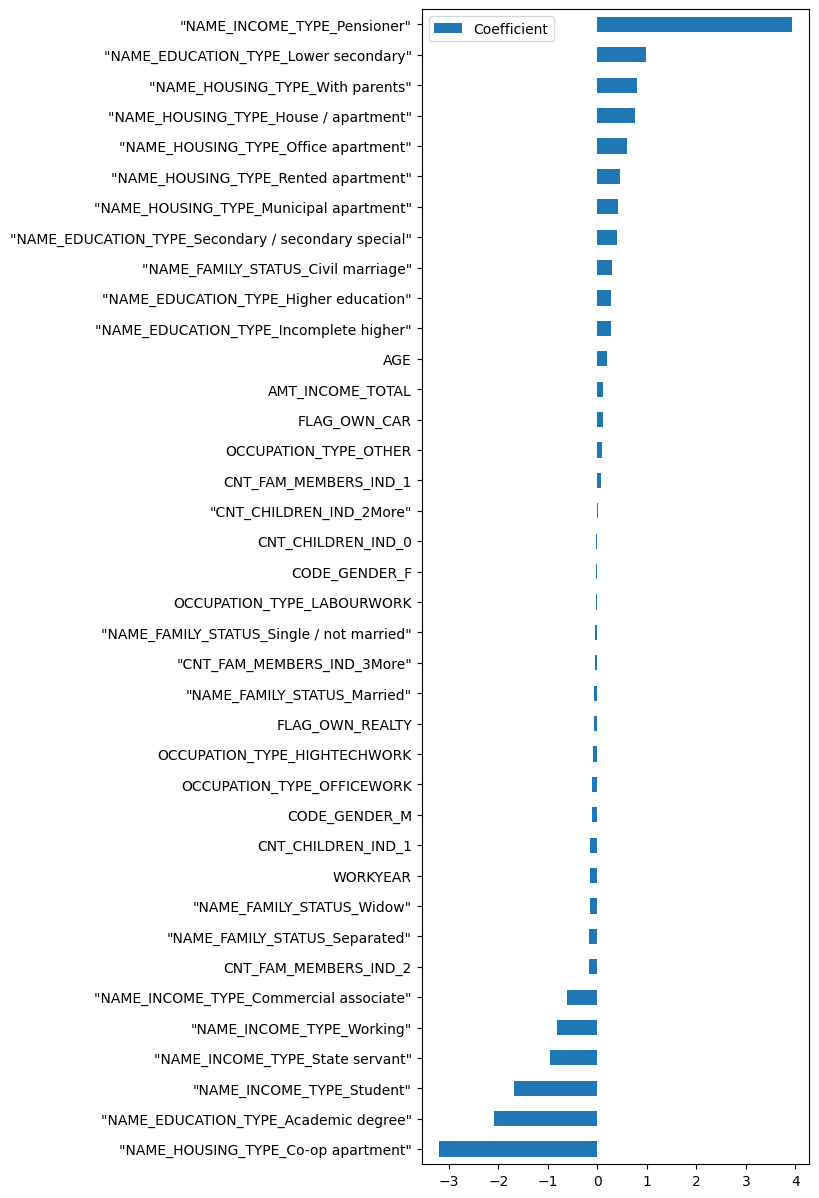

In [20]:
feature_coefficients = pandas.DataFrame(lm_local.coef_.T,lm_local.feature_names_in_,columns=['Coefficient'])
feature_coefficients.sort_values('Coefficient').plot.barh(y='Coefficient', figsize=(5,15))

## Model Scoring

Using the predict method of the snowpark-ml model will push down the scoring into Snowflake, it can be applied on a Snowpark DataFrame or a Pandas DataFrame

In [21]:
scored_snowml_sdf = lm.predict(test_sdf)
# Saving it as a table so we do not call the predict function when using the scored DataFrame
scored_snowml_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy==1.25.2'. Your UDF might not work when the package version is different between the server and your local environment.


## Model Evaluation

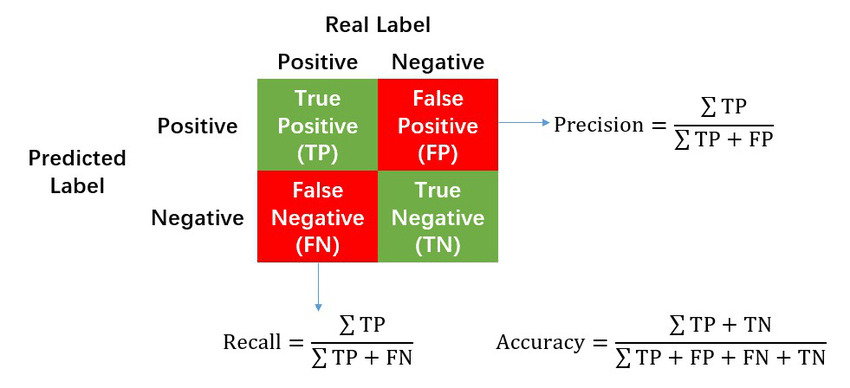

In [22]:
scored_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED')

The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


<Axes: >

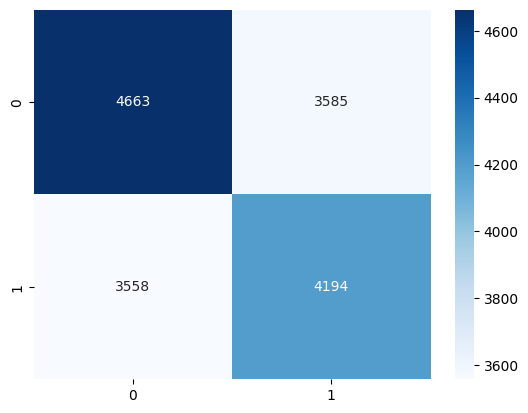

In [30]:
# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='PREDICTION')

seaborn.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

In [33]:
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))

Acccuracy: 0.555121


The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Precision: 0.5481733524355301


The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


Recall: 0.5416740399929216


The version of package 'numpy' in the local environment is 1.25.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


F1: 0.5449043168669337
